In [1]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
texts = ['먹고 싶은 사과', '먹고 싶은 바나나', '길고 노란 바나나 바나나', '저는 과일이 좋아요']

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
print(tokenizer.word_index)

{'바나나': 1, '먹고': 2, '싶은': 3, '사과': 4, '길고': 5, '노란': 6, '저는': 7, '과일이': 8, '좋아요': 9}


In [4]:
print(tokenizer.texts_to_matrix(texts, mode = 'count')) # texts_to_matrix의 입력으로 texts를 넣고, 모드는 'count'

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


In [5]:
print(tokenizer.texts_to_matrix(texts, mode = 'binary'))

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


In [6]:
print(tokenizer.texts_to_matrix(texts, mode = 'tfidf').round(2)) # 둘째 자리까지 반올림하여 출력

[[0.   0.   0.85 0.85 1.1  0.   0.   0.   0.   0.  ]
 [0.   0.85 0.85 0.85 0.   0.   0.   0.   0.   0.  ]
 [0.   1.43 0.   0.   0.   1.1  1.1  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.1  1.1  1.1 ]]


In [7]:
print(tokenizer.texts_to_matrix(texts, mode = 'freq').round(2)) # 둘째 자리까지 반올림하여 출력

[[0.   0.   0.33 0.33 0.33 0.   0.   0.   0.   0.  ]
 [0.   0.33 0.33 0.33 0.   0.   0.   0.   0.   0.  ]
 [0.   0.5  0.   0.   0.   0.25 0.25 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.33 0.33 0.33]]


In [8]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [9]:
newsdata = fetch_20newsgroups(subset = 'train') # 'train'을 기재하면 훈련 데이터만 리턴한다.

In [10]:
print(newsdata.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [11]:
print('훈련용 샘플의 개수 : {}'.format(len(newsdata.data)))

훈련용 샘플의 개수 : 11314


In [12]:
print('총 주제의 개수 : {}'.format(len(newsdata.target_names)))
print(newsdata.target_names)

총 주제의 개수 : 20
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [13]:
data = pd.DataFrame(newsdata.data, columns = ['email'])
data['target'] = pd.Series(newsdata.target)
data[:5]

,email,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   11314 non-null  object
 1   target  11314 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 132.7+ KB


In [15]:
data.isnull().values.any()

False

In [16]:
print('중복을 제외한 샘플의 수 : {}'.format(data['email'].nunique()))
print('중복을 제외한 주제의 수 : {}'.format(data['target'].nunique()))

중복을 제외한 샘플의 수 : 11314
중복을 제외한 주제의 수 : 20


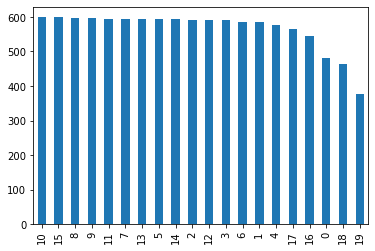

In [17]:
data['target'].value_counts().plot(kind='bar');

In [18]:
print(data.groupby('target').size().reset_index(name='count'))

    target  count
0        0    480
1        1    584
2        2    591
3        3    590
4        4    578
5        5    593
6        6    585
7        7    594
8        8    598
9        9    597
10      10    600
11      11    595
12      12    591
13      13    594
14      14    593
15      15    599
16      16    546
17      17    564
18      18    465
19      19    377


In [19]:
newsdata_test = fetch_20newsgroups(subset='test', shuffle=True)
train_email = data['email']
train_label = data['target']
test_email = newsdata_test.data
test_label = newsdata_test.target

In [20]:
vocab_size = 10000
num_classes = 20

In [21]:
def prepare_data(train_data, test_data, mode): # 전처리 함수
    tokenizer = Tokenizer(num_words = vocab_size) # vocab_size 개수만큼의 단어만 사용한다.
    tokenizer.fit_on_texts(train_data)
    X_train = tokenizer.texts_to_matrix(train_data, mode=mode) # 샘플 수 × vocab_size 크기의 행렬 생성
    X_test = tokenizer.texts_to_matrix(test_data, mode=mode) # 샘플 수 × vocab_size 크기의 행렬 생성
    return X_train, X_test, tokenizer.index_word

In [22]:
X_train, X_test, index_to_word = prepare_data(train_email, test_email, 'binary') # binary 모드로 변환
y_train = to_categorical(train_label, num_classes) # 원-핫 인코딩
y_test = to_categorical(test_label, num_classes) # 원-핫 인코딩

In [23]:
print('훈련 샘플 본문의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 본문의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 본문의 크기 : (11314, 10000)
훈련 샘플 레이블의 크기 : (11314, 20)
테스트 샘플 본문의 크기 : (7532, 10000)
테스트 샘플 레이블의 크기 : (7532, 20)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [25]:
def fit_and_evaluate(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(256, input_shape=(vocab_size,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.1)
    score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
    return score[1]

In [26]:
modes = ['binary', 'count', 'tfidf', 'freq'] # 4개의 모드를 리스트에 저장.

for mode in modes: # 4개의 모드에 대해서 각각 아래의 작업을 반복한다.
    X_train, X_test, _ = prepare_data(train_email, test_email, mode) # 모드에 따라서 데이터를 전처리
    score = fit_and_evaluate(X_train, y_train, X_test, y_test) # 모델을 훈련하고 평가.
    print(mode+' 모드의 테스트 정확도:', score)

Epoch 1/5
80/80 [==============================] - 1s 15ms/step - loss: 2.3224 - accuracy: 0.3350 - val_loss: 1.0023 - val_accuracy: 0.8251
Epoch 2/5
80/80 [==============================] - 1s 12ms/step - loss: 0.9056 - accuracy: 0.7565 - val_loss: 0.4715 - val_accuracy: 0.8905
Epoch 3/5
80/80 [==============================] - 1s 13ms/step - loss: 0.4391 - accuracy: 0.8857 - val_loss: 0.3647 - val_accuracy: 0.8940
Epoch 4/5
80/80 [==============================] - 1s 13ms/step - loss: 0.2587 - accuracy: 0.9323 - val_loss: 0.3306 - val_accuracy: 0.9081
Epoch 5/5
80/80 [==============================] - 1s 12ms/step - loss: 0.1649 - accuracy: 0.9621 - val_loss: 0.3150 - val_accuracy: 0.9064
binary 모드의 테스트 정확도: 0.829792857170105
Epoch 1/5
80/80 [==============================] - 1s 14ms/step - loss: 2.7932 - accuracy: 0.2450 - val_loss: 1.6556 - val_accuracy: 0.7350
Epoch 2/5
80/80 [==============================] - 1s 12ms/step - loss: 1.4320 - accuracy: 0.6297 - val_loss: 0.7054 - val